In [21]:
import os
import torch
import torchvision
import torch.nn as nn
import pickle
import pylab
import numpy as np
import scipy
import torch.optim as optim
import pandas as pd
import torchvision.datasets as datasets

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import shapiro, normaltest

from torchvision import transforms

from copy import deepcopy

# Local imports
from local_models import *
from helper_functions import *
from piece_hurdle_model import *

from IPython.display import Image

from PIL import Image

# torch.autograd.set_detect_anomaly(True)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# we should direct find a image for original_query_idx, original_query_img, original_query_label
# data\correct_img\correct_img2\true_label_Bag_predicted_label_Bag_26.png

In [2]:
G_Fashion, cnn_Fashion = load_models_Fashion(CNN, Generator)
train_loader_fashion, test_loader_fashion = load_dataloaders_fashion()

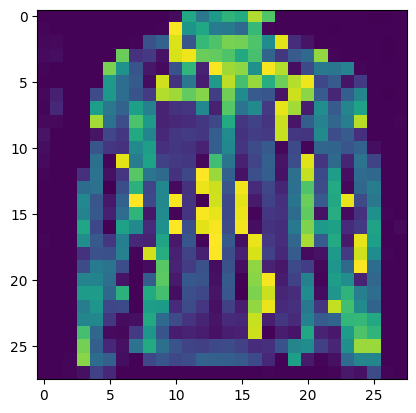

In [28]:
png_path = 'data\\correct_gen_img\\correct_gen_img2\\true_label_Coat_predicted_label_Coat_16.png'
original_query_img_fashion = load_png_as_mnist_format(png_path)
plt.imshow(original_query_img_fashion.detach().squeeze().numpy())

In [29]:
original_query_pred_fashion = int(torch.argmax(cnn_Fashion(original_query_img_fashion)[0]))
original_query_label = np.float64(original_query_pred_fashion)
output_label(original_query_pred_fashion)

'Coat'

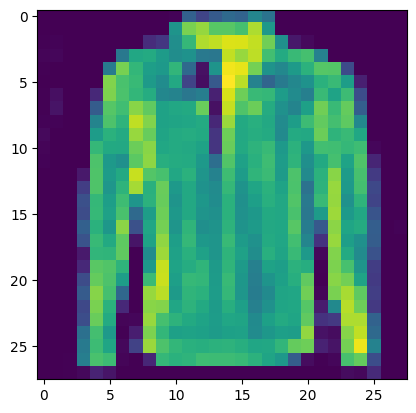

In [30]:
z = torch.load('data\\correct_latent_z\\correct_latent_z2\\true_label_Coat_predicted_label_Coat_16.pt', map_location='cpu')
output = G_Fashion(z)
img_GANs = output.detach().squeeze().numpy()
plt.imshow(img_GANs)

In [31]:
query_activations = cnn_Fashion(G_Fashion(z))[1][0]
len(query_activations)

128

In [32]:
#### ========== First step of PIECE Algorithm ========== ####
# Step 1: Acquire the probability of each features, 
# and identify the excpetional ones (i.e., those with a probability lower than alpha)


target_class = 6  # we want it will be predicted as in sneaker Class, see in the last block, how to fine the example
alpha = 0.1
df = acquire_feature_probabilities_Fashion( target_class, cnn_Fashion,
                                   original_query_img_fashion,
                                   alpha) 
df

,Feature Map,Contribution,Bern Fail,Bern Success,Cont High,Cont Low,Expected Value,Probability of Event,Distribtuion p-value KsTest,Dist Type
0,0,0.0000,True,False,False,False,0.2253,0.0169,0.0000,expon With Fixed 0 Location
1,1,0.0000,True,False,False,False,0.1782,0.0497,0.0234,gamma
2,2,-0.0019,False,False,False,True,0.1263,0.0184,0.4428,gamma With Fixed 0 Location
3,3,0.0000,True,False,False,False,0.3744,0.0180,0.0077,gamma
4,4,-0.0000,False,False,False,False,0.0473,0.2446,0.2395,expon With Fixed 0 Location
...,...,...,...,...,...,...,...,...,...,...
123,123,0.0000,False,False,False,False,0.0681,0.5929,0.2682,gamma
124,124,1.0910,False,False,False,False,0.5526,0.4563,0.7113,gamma
125,125,-0.0000,False,False,False,False,0.0939,0.2931,0.0699,gamma With Fixed 0 Location
126,126,0.0622,False,False,False,False,0.1627,0.1252,0.0000,gamma


In [33]:
df = filter_df_of_exceptional_noise(df, target_class, cnn_Fashion, alpha=alpha)
df = df.sort_values('Probability of Event')
df

d:\Master_ML\iml\project-we-are-3\Explanation\helper_functions.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['flag'] = np.zeros(df.shape[0])


,Feature Map,Contribution,Bern Fail,Bern Success,Cont High,Cont Low,Expected Value,Probability of Event,Distribtuion p-value KsTest,Dist Type
39,39,0.0000,True,False,False,False,0.0001,0.0000,0.0000,norm
116,116,0.0000,True,False,False,False,0.0001,0.0000,0.0000,norm
52,52,0.0000,True,False,False,False,0.0001,0.0000,0.0000,norm
6,6,0.0000,True,False,False,False,0.5397,0.0013,0.1256,gamma
75,75,0.0000,True,False,False,False,0.4305,0.0013,0.0204,gamma
108,108,0.0000,True,False,False,False,0.4462,0.0015,0.0000,gamma
99,99,0.0000,True,False,False,False,0.4583,0.0026,0.1403,gamma
72,72,-2.7821,False,False,True,False,0.0435,0.0046,0.0000,gamma
29,29,0.0950,False,False,False,True,0.6572,0.0047,0.0000,gamma With Fixed 0 Location
73,73,-3.5019,False,False,True,False,0.0936,0.0075,0.0065,gamma With Fixed 0 Location


In [34]:
len(df)

47

In [35]:
def semi_factual_optim(df, target_class, query_activations, cnn):
	"""
	A greedy optimization towards the nearest counterfactual instance
	"""

	ideal_xp = query_activations.clone().detach()
	changed = 0
	distances = list()
	results = list()
	
	for idx, row in df.sort_values('Probability of Event', ascending=True).iterrows():
		feature_idx = int(row['Feature Map'])  
		expected_value = row['Expected Value'] 
		ideal_xp[feature_idx] = expected_value
		changed += 1
		pred = int(torch.argmax(  cnn.classifier(ideal_xp.reshape(1,-1))  ))

		# Once the pred changed to target class break the loop, and return the latent x
		if pred == target_class:
			ideal_xp[feature_idx] = query_activations[feature_idx]
			break

	return ideal_xp, changed

In [36]:
ideal_xp, changed = semi_factual_optim(df, target_class, query_activations, cnn_Fashion)
changed

7

In [37]:

# Explanation latent input (to optimize...)
z_e = z.clone().detach().float().requires_grad_(True)
criterion = nn.MSELoss()
optimizer = optim.Adam([z_e], lr=0.01)

for i in range(1500):

    optimizer.zero_grad()
    logits, x_e = cnn_Fashion(G_Fashion(z_e))
    loss = criterion(x_e[0], ideal_xp)

    loss.backward(retain_graph=True)  
    optimizer.step()  

    if i % 500 == 0:
        print("Loss:", loss.item())


Loss: 0.0016705358866602182
Loss: 0.0010105036199092865
Loss: 0.0009285310516133904


## Semi-factual Explanation
the orginal image is classified as coat, now it changs to Shirt. After modifying 7 exceptional latent features, the class of the image changed, indicating that the image was originally very close to the decision boundary. Thus, making minor adjustments resulted in a change in the CNN's decision. However, these changes are imperceptible to humans.

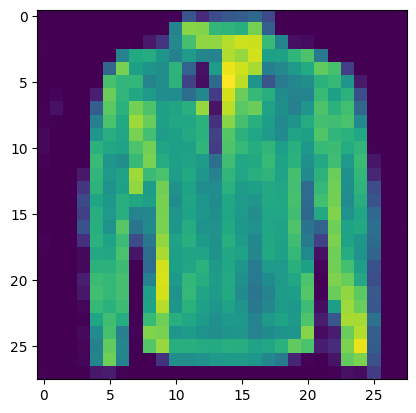

In [39]:
plt.imshow( G_Fashion(z_e).detach().numpy()[0][0])

## Find Example Pictrue

In [6]:
def find_cf_gradient_ascent(z, lr, G, target_class, cnn):

	z_temp = z.clone().detach().requires_grad_(True)
	optimizer = optim.Adam([z_temp], lr=lr)
	criterion = torch.nn.MSELoss()
	output_t = torch.tensor([0,0,0,0,0,0,0,0,0,0], dtype=torch.float32)
	output_t[target_class] = 1
	epoch = 0

	while True:
		epoch += 1
		optimizer.zero_grad()

		output_e_raw = cnn(G(z_temp))[0] 
		output_e = torch.nn.functional.softmax(output_e_raw, dim=1)[0]
		loss = criterion(output_e, output_t)
		(-loss).backward(retain_graph=True)  
		optimizer.step()

		pred = int(torch.argmax(output_e))
		if epoch % 300 == 0:
			print("iteration: ", epoch)
  
  
		if pred != target_class:
			return pred, z_temp


		if epoch == 30000:
			return None, z_temp


In [11]:
target_class, z_temp = find_cf_gradient_ascent(z, 0.1, G_Fashion, int(original_query_label), cnn_Fashion)
print("Counterfactual Class is:", target_class)

Counterfactual Class is: 6


## looking throught the all 50 images

In [ ]:
files = os.listdir('data\correct_img\correct_img2')
counter = 0

for file in files:
    path = os.path.join('data\correct_img\correct_img2', file)
    original_query_img_fashion = load_png_as_mnist_format(path)
    
    original_query_label = np.float64(output_label(file.split('_')[5], reverse=True))
    original_query_pred_fashion = int(torch.argmax(cnn_Fashion(original_query_img_fashion)[0]))
    z_path = os.path.join('data\correct_latent_z\correct_latent_z2', file.replace('.png', '.pt'))
    
    z = torch.load(z_path, map_location='cpu')
    # query_activations = cnn_Fashion(G_Fashion(z))[1][0]
    target_class = find_cf_gradient_ascent(z, 0.1, G_Fashion, int(original_query_label), cnn_Fashion)
    
    if target_class:
        counter += 1
        print("Counterfactual Class is:", output_label(target_class))
        print("idx:", file.split('_')[6])
        output = G_Fashion(z)
        img_GANs = output.detach().squeeze().numpy()
        plt.imshow(img_GANs)
        plt.show()
        